In [3]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import pickle

from get_coords import get_coords, domains
from G_phi_psi import make_distmap

import seaborn as sns

/home/tomas/miniconda3/envs/pyml/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/tomas/miniconda3/envs/pyml/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/tomas/miniconda3/envs/pyml/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/tomas/miniconda3/envs/pyml/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


load data

In [2]:
# real distmap
coords = get_coords('16pkA01')
c = []
for i in coords:
    if i[3] == 'CA' and i[2] == 'G':
        c.append(i[4:])
    elif i[3] == 'CB':
        c.append(i[4:])
        
c = torch.tensor(c, dtype=torch.float)

dist_map_real = make_distmap(c)

# sequence
seq = domains['16pkA01'][2]

In [3]:
with open('outputs/16pk.out', 'rb') as f:
    d = pickle.load(f)

In [4]:
distogram = d['distogram']

In [5]:
distogram.shape

torch.Size([32, 188, 188])

In [5]:
x = torch.linspace(2, 22, 31)
x

tensor([ 2.0000,  2.6667,  3.3333,  4.0000,  4.6667,  5.3333,  6.0000,  6.6667,
         7.3333,  8.0000,  8.6667,  9.3333, 10.0000, 10.6667, 11.3333, 12.0000,
        12.6667, 13.3333, 14.0000, 14.6667, 15.3333, 16.0000, 16.6667, 17.3333,
        18.0000, 18.6667, 19.3333, 20.0000, 20.6667, 21.3333, 22.0000])

## Cubic spline interpolation

In [125]:
P.searchsorted(x[1:], x)

tensor([ 0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [30]:
def torch_searsort(x, xs):
    x = torch.cat((torch.tensor([-10.0]), x, torch.tensor([10000.0])))
    ind = 0
    for i in range(1, len(x) - 1):
        if x[i-1] < xs and xs <= x[i]:
            return i - 1

In [31]:
torch.tensor([torch_searsort2(x[1:], i) for i in x])

tensor([ 0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [4]:
# Copied from 
# https://stackoverflow.com/questions/61616810/how-to-do-cubic-spline-interpolation-and-integration-in-pytorch

def h_poly_helper(tt):
    A = torch.tensor([
      [1, 0, -3, 2],
      [0, 1, -2, 1],
      [0, 0, 3, -2],
      [0, 0, -1, 1]
      ], dtype=tt[-1].dtype)
    return [
            sum( A[i, j]*tt[j] for j in range(4) )
            for i in range(4) ]

def h_poly(t):
    tt = [ None for _ in range(4) ]
    tt[0] = 1
    for i in range(1, 4):
        tt[i] = tt[i-1]*t
    return h_poly_helper(tt)

def interp(x, y, xs):  
    
    m = (y[1:] - y[:-1])/(x[1:] - x[:-1])
    m = torch.cat([m[[0]], (m[1:] + m[:-1])/2, m[[-1]]])
    I = torch_searsort(x, xs)
    dx = (x[I+1]-x[I])
    hh = h_poly((xs-x[I])/dx)
    return hh[0]*y[I] + hh[1]*m[I]*dx + hh[2]*y[I+1] + hh[3]*m[I+1]*dx

In [146]:
interp(x, distogram[1:, 15, 7], x[0])

tensor(1.0076e-06)

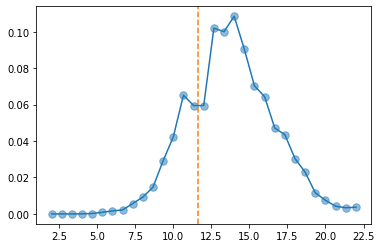

In [147]:
y = [interp(x, distogram[1:, 15, 7], i) for i in x]

plt.plot(x, distogram[1:, 15, 7], '.', markersize=15, alpha=0.5, c='C0')
plt.plot(x, y, c='C0')
plt.axvline(dist_map_real[15, 7], ls='--', c = 'C1');

# Fit von Mises distribution to the torsion angles

In [22]:
from scipy.stats import vonmises

In [14]:
phi, psi = d['phi'], d['psi']

In [15]:
xtorsion = torch.linspace(-np.pi, np.pi, 36)
xtorsion

tensor([-3.1416, -2.9621, -2.7826, -2.6030, -2.4235, -2.2440, -2.0645, -1.8850,
        -1.7054, -1.5259, -1.3464, -1.1669, -0.9874, -0.8078, -0.6283, -0.4488,
        -0.2693, -0.0898,  0.0898,  0.2693,  0.4488,  0.6283,  0.8078,  0.9874,
         1.1669,  1.3464,  1.5259,  1.7054,  1.8850,  2.0645,  2.2440,  2.4235,
         2.6030,  2.7826,  2.9621,  3.1416])

In [16]:
vmexp = torch.sum(xtorsion * phi[0, 1:, 0, 0])
vmvar = torch.sum(xtorsion ** 2 * phi[0, 1:, 0, 0]) - vmexp
vmkappa = 1 / vmvar

In [17]:
vonmises.pdf(xtorsion, loc=vmexp, kappa=vmkappa)

array([0.10448706, 0.1108342 , 0.11873273, 0.12817155, 0.13908158,
       0.15130875, 0.16458821, 0.17852519, 0.19258909, 0.20612793,
       0.21840706, 0.22867224, 0.23623056, 0.24053633, 0.24126541,
       0.238362  , 0.23204678, 0.22278473, 0.21122012, 0.198093  ,
       0.18415462, 0.17009605, 0.15649929, 0.14381363, 0.13235402,
       0.12231585, 0.11379885, 0.10683411, 0.10140994, 0.0974938 ,
       0.09504931, 0.09404831, 0.09447802, 0.09634401, 0.09966894,
       0.10448707])

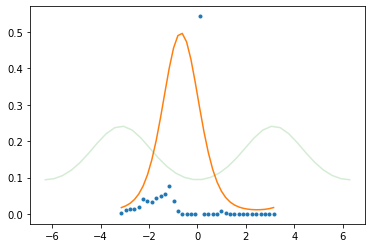

In [18]:
plt.plot(xtorsion, phi[0, 1:, 0, 0], '.')
plt.plot(xtorsion, vonmises.pdf(xtorsion, loc=vmexp, kappa=4*vmkappa), '-')
xt2 = torch.linspace(-2*np.pi, 2*np.pi, 36)
plt.plot(xt2, vonmises.pdf(xt2, loc=np.pi, kappa=vmkappa), '-', alpha=0.2)

In [19]:
rvm = vonmises.rvs(size=100, kappa=vmkappa, loc=np.pi)

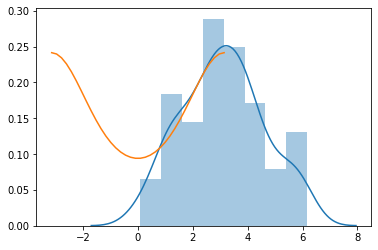

In [20]:
sns.distplot(rvm)
plt.plot(xtorsion, vonmises.pdf(xtorsion, loc=np.pi, kappa=vmkappa))

### Random Sampler from von Mises distribution

In [5]:
def randvonmises(anglegram, i, kappa_scalar=8, random_state=1):
    
    xtorsion = torch.linspace(-np.pi, np.pi, 36)
    
    vmexp = torch.sum(xtorsion * anglegram[0, 1:, 0, i])
    vmvar = torch.sum(xtorsion ** 2 * anglegram[0, 1:, 0, i]) - vmexp
    vmkappa = 1 / vmvar
    
    randvar = vonmises.rvs(kappa=kappa_scalar*vmkappa, loc=vmexp)
    if randvar < -np.pi:
        randvar = 2 * np.pi + randvar
    elif randvar > np.pi:
        randvar = - 2 * np.pi + randvar
    return randvar

In [16]:
def sample_torsion(phi, psi, kappa_scalar=8):
    """
    Samples one value from each von mises distribution fitted to 
    each histogram. Kappa is calculated as 1/var * kappa_scalar, to 
    make it more narrow
    """
    
    #phi_s = phi[:, :, :, 1:]
    #psi_s = psi[:, :, :, :-1]
    
    phi_sample = torch.tensor(np.round([randvonmises(phi, i, kappa_scalar) for i in range(phi.shape[3])], 4))
    psi_sample = torch.tensor(np.round([randvonmises(psi, i, kappa_scalar) for i in range(psi.shape[3])], 4))
    return phi_sample, psi_sample
    

### Differentiable von mises distribution

In [7]:
import pyro  # requires installation of pyro: conda install -c gwerbin pyro-ppl
vm = pyro.distributions.von_mises.VonMises(0, 4)
vm.log_prob(0)

tensor(-0.2628)

In [17]:
def fit_vm(anglegram, kappa_scalar=8):
    distros = []
    xtorsion = torch.linspace(-np.pi, np.pi, 36)
    
    for i in range(anglegram.shape[3]):
        vmexp = torch.sum(xtorsion * anglegram[0, 1:, 0, i])
        vmvar = torch.sum(xtorsion ** 2 * anglegram[0, 1:, 0, i]) - vmexp
        vmkappa = kappa_scalar / vmvar
        
        vm = pyro.distributions.von_mises.VonMises(vmexp, vmkappa)
        distros.append(vm)
    return distros

In [199]:
vmphi = fit_vm(phi)
vmpsi = fit_vm(psi)

In [208]:
len(vmphi)

188

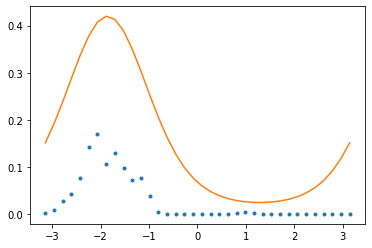

In [200]:
ind=30

yy = torch.tensor([torch.exp(vmphi[ind].log_prob(i)) for i in xtorsion])
plt.plot(xtorsion, phi[0, 1:, 0, ind], '.')
plt.plot(xtorsion, yy)

# Loss function(s)

In [26]:
from structure import Structure

In [18]:
phi_sample, psi_sample = sample_torsion(phi, psi, kappa_scalar=4)
p16pk = Structure(phi_sample, psi_sample, seq)

NameError: name 'phi' is not defined

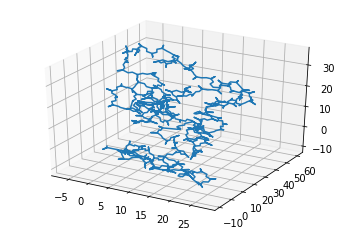

In [274]:
p16pk.visualize_structure()

In [23]:
def NLLLoss(structure, distogram, vmphi, vmpsi):
    """
    Loss Function consisting of two potentials:
        distance potential
        torsion angle potential
    
    distance potential is the log of a probability of a distance value
    from a distribution to which a cubic spline is fitted
    
    angle potential 
    """
    
    x = torch.linspace(2, 22, 31)
    xtorsion = torch.linspace(-np.pi, np.pi, 36)
    
    loss = 0
    # DISTANCE POTENTIAL
    distance_map = structure.G()
    for i in range(len(distance_map)):
        for j in range(len(distance_map)):
            if i == j:
                pass
            else:
                loss += 1/2 * torch.log(max(torch.tensor(0.001),
                                            interp(x, distogram[1:, i, j], min(torch.tensor(22), 
                                                                               distance_map[i, j]))))
    # TORSION ANGLE POTENTIAL
    for i in range(len(structure.phi)):
        # torsion angle loss phi
        loss += vmphi[i].log_prob(structure.torsion[i])
        # torsion angle loss psi
        loss += vmpsi[i].log_prob(structure.torsion[len(structure.phi) + i])

    return -loss

In [32]:
from copy import copy
def optimize(domain,
             kappa_scalar=8,
             iterations=100, 
             lr=1e-3, 
             lr_decay=1,
             min_lr=1e-10,
             decay_frequency=10,
             normalize_gradients=True,
             momentum=0,
             nesterov=False,
             verbose=1, 
             img_dir=None):
    """
    Optimize structure (phi and psi angles) given a label
    """
    
    # Load predicted data
    
    with open(f'outputs/{domain}.out', 'rb') as f:
        d = pickle.load(f)
    
    distogram, phi, psi = d['distogram'], d['phi'], d['psi']
    
    # remove first phi angle and last psi angle
    # necessary because the first atom we place is Nitrogen and last is Carbon-C
    phi = phi[:, :, :, 1:]
    psi = psi[:, :, :, :-1]
    
    # sample angles from von Mises distribution fitted to each histogram in angleograms
    phi_sample, psi_sample = sample_torsion(phi, psi, kappa_scalar)
    
    # fit continuous von Mises distribution to each histogram in angleograms
    vmphi = fit_vm(phi)
    vmpsi = fit_vm(psi)
    
    # load sequence
    # with open(f'../../data/our_input/sequences/{domain}.fasta') as f:
    #     f.readline()  # fasta header
    #     seq = f.readline()
    
    #seq = domains[f'{domain}'][2]
    with open('1a02F00.fasta') as f:
        f.readline()
        seq = f.readline()
    
    # Create Structure - Model of protein geometry
    structure = Structure(phi_sample, psi_sample, seq)
    s0 = copy(structure)
    # OPTIMIZE, OPTIMIZE, OPTIMIZE
    
    history = []
    min_loss = np.inf
    
    if momentum > 1 or momentum < 0:
        print('Momentum parameter has to be between 0 and 1')
        return
    
    # initialize V for momentum
    V = torch.zeros((len(structure.torsion)))
    
    for i in range(iterations):
        if structure.torsion.grad is not None:
            structure.torsion.grad.zero_()
        
        if nesterov:
            structure.torsion = (structure.torsion + momentum * V).detach().requires_grad_()
            
        L = NLLLoss(structure, distogram, vmphi, vmpsi)
        L.backward()

        if normalize_gradients:
            # normalize gradients
            structure.torsion.grad = (structure.torsion.grad - torch.mean(structure.torsion.grad)) / torch.std(structure.torsion.grad)
        
        # Implementing momentum
        V = momentum * V - lr * structure.torsion.grad
        
        structure.torsion = (structure.torsion + V).detach().requires_grad_()
        
        if verbose is not None:
            if i % verbose == 0:
                print(f'Iteration {i}, Loss: {L.item()}')
                
        history.append([i, L.item()])
        
        if i % decay_frequency == 0 and i > 0:
            lr *= lr_decay
        
        if L.item() < min_loss:
            best_structure = copy(structure)
            min_loss = L.item()
            
        if img_dir is not None:
            structure.visualize_structure('{}/iter_{:04d}.png'.format(img_dir, i))
        
        if lr < min_lr:
            break
            
    return best_structure, s0, min_loss, np.array(history)

In [33]:
s, s0, l, h = optimize('1a02F00', lr=0.01, lr_decay=0.9, iterations=10, verbose=10)

Iteration 0, Loss: 4960.31201171875


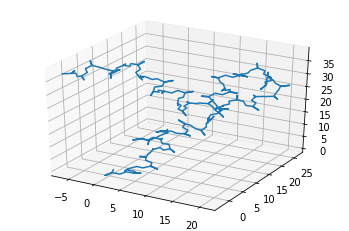

In [34]:
s0.visualize_structure()

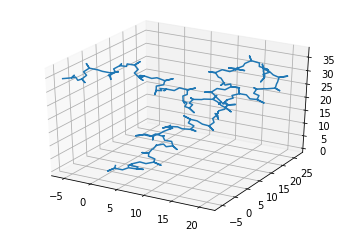

In [35]:
s.visualize_structure()

In [36]:
from Bio.PDB.Polypeptide import one_to_three

In [442]:
backbone, cbeta = s.G_full()
seq = s.seq

In [443]:
backbone = backbone.data.numpy()
cbeta = cbeta.data.numpy()

In [444]:
str(backbone[0][1])

'1.3536917'

In [46]:
def pdb_atom(ind, a, aa, chain, pos, xyz):
    atom = 'ATOM {:>6}  {:3} {:3} {:1} {:>4}   '.format(ind, a, one_to_three(aa), chain, pos)
    atom += '{:7.3f} {:7.3f} {:7.3f} X X X'.format(xyz[0], xyz[1], xyz[2])
    return atom

In [38]:
pdb_atom(0, 'N', 'G', 'F', 10, backbone[0])

NameError: name 'backbone' is not defined

In [47]:
from Bio.PDB.Polypeptide import one_to_three

def pdb_coords(structure, chain='X', position_start=0):
    
    backbone, cbeta = structure.G_full()
    seq = structure.seq
    
    # Round
    backbone = np.round(backbone.data.numpy(), 4)
    cbeta = np.round(cbeta.data.numpy(), 4)
    
    coords_full = []

    ind = 0
    bind = 0 # backbone ind
    cbind = 0
    for i in range(len(seq)):

        # Backbone atoms
        for j, a in enumerate(['N', 'CA', 'C']):
            coords_full.append(pdb_atom(ind + j, a, seq[i], chain, position_start + i, backbone[bind+j]))

        ind += 3

        # C beta atom
        if seq[i] != 'G':
            coords_full.append(pdb_atom(ind, 'CB', seq[i], chain, position_start + i, cbeta[cbind]))
            cbind += 1
            ind += 1

        bind += 3
        
    return coords_full

In [48]:
c = pdb_coords(s)

In [49]:
c[:10]

['ATOM      0  N   ARG X    0     0.000   1.354   0.000 X X X',
 'ATOM      1  CA  ARG X    0     0.520   0.000   0.000 X X X',
 'ATOM      2  C   ARG X    0     2.040   0.000   0.000 X X X',
 'ATOM      3  CB  ARG X    0    -0.226  -1.085  -0.760 X X X',
 'ATOM      4  N   ARG X    1     2.623   1.131   0.388 X X X',
 'ATOM      5  CA  ARG X    1     4.065   1.274   0.437 X X X',
 'ATOM      6  C   ARG X    1     4.622   0.729   1.742 X X X',
 'ATOM      7  CB  ARG X    1     4.715   2.491  -0.201 X X X',
 'ATOM      8  N   ILE X    2     3.822  -0.087   2.422 X X X',
 'ATOM      9  CA  ILE X    2     4.222  -0.681   3.683 X X X']

In [50]:
from datetime import date

In [52]:
domain = '1a02F00'
with open('outputs/1a02F00_out.pdb', 'w') as f:
    f.write('HEADER ' + str(date.today()) + '\n')
    f.write(f'TITLE Prediction of {domain}\n')
    f.write('AUTHOR Thinking Potato\n')
    for i in range(len(c)):
        f.write(c[i] + '\n')

In [421]:
str(date.today())

'2020-05-06'

In [1]:
from structure import Structure